# Programme segmentation d'un stack d'images

## Intégration des librairies

In [3]:
%matplotlib notebook
from PIL import Image
import matplotlib.pyplot as plt
plt.isinteractive()
import os 
import numpy as np 
from scipy.signal import argrelextrema
from tqdm import tqdm
import os
from scipy import interpolate, signal, ndimage
from sympy import *
import sys
from numba import jit
import numba
import cv2
from time import sleep

## Ouverture du fichier d'images

In [1]:
data_dir = "F://Dossier_KevinCO/Scan_001_Os_implant/SlicesY/" #chemin du dossier d'images
out_dir = "./data/"
object_list = ["vide", "os", "implant", "trocart"] #liste des sujets segmentés vide compris, du moins dense au plus dense
format_type = ".tif" #format de l'image

## Création des dossiers des images segmentées 

In [4]:

dossier = "Segmentation" #nom du dossiers
parent_dir = "D:/" #chemin de sauvegarde
os.mkdir(os.path.join(parent_dir, dossier))

directory = object_list #nom des dossiers
child_dir = "D://Segmentation/" #chemin de sauvegarde

for i in range(len(directory)):
    os.mkdir(os.path.join(child_dir, directory[i]))
print("Folder '% s' has been created" % dossier) 
print("Folder '% s' has been created in Segmentation" % directory ) 

##segmentation multiple##
dossier = "Segmentation_multiple" #nom du dossiers
parent_dir = "D:/" #chemin de sauvegarde
os.mkdir(os.path.join(parent_dir, dossier))

directory = object_list #nom des dossiers
child_dir1 = "D://Segmentation_multiple/" #chemin de sauvegarde

for i in range(len(directory)):
    os.mkdir(os.path.join(child_dir1, directory[i]))
print("Folder '% s' has been created" % dossier) 
print("Folder '% s' has been created in Segmentation_multiple" % directory ) 

Folder 'Segmentation' has been created
Folder '['vide', 'os', 'implant', 'trocart']' has been created in Segmentation
Folder 'Segmentation_multiple' has been created
Folder '['vide', 'os', 'implant', 'trocart']' has been created in Segmentation_multiple


## Definition

In [4]:
@jit(nopython=True)
def ChangePixelValue(source, coordonates, value):
    image = source.copy()
    for i in range(len(coordonates)):
        image[coordonates[i][0],coordonates[i][1]] = value
    return image

@jit(nopython=True)
def Wrapper(coordonates, value_r, value_g, value_b,image_rgb):
    for i in range(len(coordonates)):
        image_rgb[:,:,:3][coordonates[i][0],coordonates[i][1]] = [value_r, value_g, value_b]   
    image_rgb = (255.0 / image_rgb.max() * (image_rgb - image_rgb.min())).astype(np.uint8)
    return image_rgb

#@vectorize([numba.uint8[:,:,::1](numba.uint16[:,::1], numba.int64[:,::1], numba.int64, numba.int64, numba.int64)])
#@guvectorize(['void(numba.uint16[:,::1], numba.int64[:,::1], numba.int64, numba.int64, numba.int64)'], '(h,w,), (,), (),(),()')
#@guvectorize(["u2[:,::1], i8[:,::1], i8, i8, i8"], "(n,m)->(n,m)")
#@jit(nopython=True)
#@overload
def ChangePixelValueGrayToRGB(source, coordonates, value_r, value_g, value_b ):
    frame = source.copy()
    image_rgb = np.dstack([frame, frame, frame]).reshape(frame.shape[0], frame.shape[1],3)
    image_rgb = Wrapper(coordonates, value_r, value_g, value_b,image_rgb)
    return image_rgb

#@jit(nopython=True)
def ImageGrayToRGB(source):
    frame = source.copy()
    image_rgb = np.dstack([frame, frame, frame]).reshape(frame.shape[0],frame.shape[1],3)  
    image_rgb = (255.0 / image_rgb.max() * (image_rgb - image_rgb.min())).astype(np.uint8)
    return image_rgb

@jit(nopython=True)
def GetPixelValue(source, value):
    position = np.where(source==value)
    zipped = np.column_stack((position))
    return zipped

@jit(nopython=True)
def GetPixelValueBetween(source, infvalue, suppvalue):
    position = np.where(np.logical_and(infvalue<source, source<suppvalue))
    zipped = np.column_stack((position))
    return zipped

@jit(nopython=True)
def GetPixelValueOutside(source, infvalue, suppvalue):
    position = np.where(np.logical_or(infvalue>source, source>suppvalue))
    zipped = np.column_stack((position))
    return zipped 

@jit(nopython=True)
def GetPixelValueBetweenSeveral(source, limits): 
    l_0 = None
    for limit in limits :
        l_1 = GetPixelValueBetween(source, limit[0], limit[1])
        if l_0 is None:
            l_0 = l_1
            continue
        else:
            l_0 = np.concatenate([l_0, l_1], axis=0)        
    return l_0

def SegHist(data_dir, impathes):
    from scipy import interpolate
    minV = 2**16 
    maxV = 0
    k = [0]*(2**16)
    for i in range(len(data_dir)):
        frame = np.asarray(Image.open(data_dir+impathes[i]))
        j = np.bincount(frame.flatten(), minlength = 2**16)
        k = np.add(k, j)

        if frame.flatten().min()<minV:
            minV = frame.flatten().min()
        if frame.flatten().max()>maxV:
            maxV = frame.flatten().max()
    interV = (maxV - minV)
    yp = k[0:2**16] 
    xp = list(range(0,2**16))
    f = interpolate.interp1d(xp, ndimage.gaussian_filter(yp, 10), kind='cubic')
    Xi = np.linspace(minV, maxV, interV)
    Yi = f(Xi)
    h= int(interV*0.01)
    dYi = (f(Xi+h)-f(Xi-h))/(2*h)
    # for local maxima
    j = argrelextrema(Yi, np.greater, order = 8*int(interV/100)) #order 9 ou 8
    # for local minima
    g = argrelextrema(Yi, np.less, order = 3*int(interV/100), mode='clip')
    lim1 = []
    lim = []
    limnew = []
    for i in range(len(object_list)):
        
        ainf = np.array(g)[np.array(g) < j[0][i]].max()
        asupp = np.array(g)[np.array(g) > j[0][i]].min()
        lim.append([Xi[ainf], Xi[asupp]])
        lim1.append([ainf, asupp])
    
        pente1 = (Yi[j[0][i]] - Yi[lim1[i][0]]) / (Xi[j[0][i]] - Xi[lim1[i][0]]) #pente de la droite
        pente2 = (Yi[lim1[i][1]] - Yi[j[0][i]]) / (Xi[lim1[i][1]] - Xi[j[0][i]]) #pente de la droite
        b1 = Yi[lim1[i][0]] #ax + 'b'
        b2 = Yi[j[0][i]] #ax + 'b'
        nx1 = (-b1)/(pente1)+Xi[lim1[i][0]] #nx lorsque y=0
        nx2 = (-b2)/(pente2)+Xi[j[0][i]] #nx lorsque y=0
        limnew.append([nx1, nx2])
        
    return lim, limnew

def limits(object_list, limnew):
        if q<len(object_list)-1 and q>0 and (limnew[q][1]>limnew[q+1][0] and limnew[q][0]<limnew[q-1][1]) :
            limin_inf = limnew[q-1][1]
            limin_supp = limnew[q+1][0]
            between = [[limnew[q][0], limnew[q-1][1]],[limnew[q+1][0], limnew[q][1]]]
            cond = 2
            return limin_inf, limin_supp, limin_inf, limin_supp, cond, between
        elif q<len(object_list)-1 and (limnew[q][1]>limnew[q+1][0]) :
            limin_inf = limnew[q][0]
            limin_supp = limnew[q+1][0]
            between_inf = limnew[q+1][0]
            between_supp = limnew[q][1]
            cond = 1
            return limin_inf, limin_supp, between_inf, between_supp, cond, None
        elif q>0 and (limnew[q][0]<limnew[q-1][1]) :
            limin_inf = limnew[q-1][1]
            limin_supp = limnew[q][1]
            between_inf = limnew[q][0]
            between_supp = limnew[q-1][1]
            cond = 1
            return limin_inf, limin_supp, between_inf, between_supp, cond, None  
        else : 
            limin_inf = limnew[q][0]
            limin_supp = limnew[q][1]
            cond = 0
            return limin_inf, limin_supp, limin_inf, limin_supp, cond, None

def Average(lst): 
    return sum(lst) / len(lst)

def SumAllFrame(data_dir, impathes):
    from time import sleep
    from tqdm import tqdm
    all_frame = []
    all_of_frame = []

    for i in tqdm(range(len(impathes))):
        frame = np.asarray(Image.open(data_dir+impathes[i])).flatten()
        all_frame =np.concatenate([all_frame, frame], axis=0)
        if len(all_frame) > ((frame.shape[0])*((1/20)*len(impathes))):
            all_of_frame = np.concatenate([all_of_frame, all_frame], axis=0)
            all_frame = []
    all_of_frame =np.concatenate([all_of_frame, all_frame], axis=0)
    all_of_frame = all_of_frame.astype(int)
    return all_of_frame

def SegHistGlobal(all_of_frame):
    m = np.bincount(all_of_frame, minlength = 2**16)
    minV = all_of_frame.min()
    maxV = all_of_frame.max()

    interV = (maxV - minV)
    yp = m[0:2**16] 
    xp = list(range(0,2**16))
    f = interpolate.interp1d(xp, ndimage.gaussian_filter(yp, 200), kind='cubic')

    Xi = np.linspace(minV, maxV, interV)
    Yi = f(Xi)
    h= int(interV*0.01)
    dYi = (f(Xi+h)-f(Xi-h))/(2*h)

    # for local maxima
    j = argrelextrema(Yi, np.greater, order = 500) #order 9 ou 8
    # for local minima
    g = argrelextrema(Yi, np.less, order = 1000)
    j = np.array(j).flatten()
    new_j =[]

    for i in range(len(j)):
        if abs((f(Xi[j[i]]+h)-f(Xi[j[i]]-h))/(2*h))>0.15:
            new_j.append(j[i])

    plt.figure()
    plt.plot(Xi, 100*dYi, "-r")
    plt.plot(Xi, Yi,"-b")

    xgcoords = Xi[g]
    for xc in xgcoords:
        plt.axvline(x=xc, color='k', linestyle='--')

    xjcoords = Xi[new_j]
    for xc in xjcoords:
        plt.axvline(x=xc, color='g', linestyle='--')
    plt.show()

    lim1 = []
    lim = []
    limnew = []
    for i in range(len(object_list)):
        
        ainf = np.array(g)[np.array(g) < j[i]].max()
        asupp = np.array(g)[np.array(g) > j[i]].min()
        lim.append([Xi[ainf], Xi[asupp]])
        lim1.append([ainf, asupp])
    
        pente1 = (Yi[j[i]] - Yi[lim1[i][0]]) / (Xi[j[i]] - Xi[lim1[i][0]]) #pente de la droite
        pente2 = (Yi[lim1[i][1]] - Yi[j[i]]) / (Xi[lim1[i][1]] - Xi[j[i]]) #pente de la droite
        b1 = Yi[lim1[i][0]] #ax + 'b'
        b2 = Yi[j[i]] #ax + 'b'
        nx1 = (-b1)/(pente1)+Xi[lim1[i][0]] #nx lorsque y=0
        nx2 = (-b2)/(pente2)+Xi[j[i]] #nx lorsque y=0
        limnew.append([nx1, nx2])
        
    return lim, limnew

@jit(nopython=True)
def rescaler(value):
    dist = value.max() - value.min()
    out_value = value / (dist) - (value.min() / dist)
    return out_value

@jit(nopython=True)
def min_val_above (array, above_value):
    array = array.flatten()
    min_val = 2**16
    for i in range(len(array)) : 
        if array[i] > above_value and min_val > array[i] : 
            min_val = array[i] 
    return min_val


def stack_of_frame(path, depth):
    stack_frame = np.zeros([m ,w, len(depth) ])
    for i in range(len(depth)):
        stack_frame[:,:,i] = np.asarray(Image.open(path))
    return stack_frame   

## Création de l'axe z du stack d'image

In [5]:
impathes = sorted([f for f in os.listdir(data_dir) if f.endswith(format_type)])
m , w  = np.asarray(Image.open(data_dir+impathes[0])).shape
frame= np.zeros([m ,w, len(impathes) ])


In [6]:
for i in range(len(impathes)):
    s_frame = stack_of_frame(data_dir+impathes[i], impathes)

KeyboardInterrupt: 

In [7]:
stack_of_frame  = []
for i in range(len(impathes)):
    frame = np.asarray(Image.open(data_dir+impathes[i]))
    stack_of_frame.append(frame)

In [21]:
stack_of_frame[1229]

array([[23772, 23793, 23844, ..., 23789, 23788, 23928],
       [23775, 23812, 23812, ..., 23826, 23874, 23954],
       [23762, 23803, 23785, ..., 23886, 23906, 23895],
       ...,
       [23720, 23703, 23721, ..., 23905, 23930, 23938],
       [23802, 23765, 23809, ..., 23921, 23989, 23918],
       [23841, 23871, 23839, ..., 23973, 23979, 24003]], dtype=uint16)

## Histogramme de toutes les images

<IPython.core.display.Javascript object>


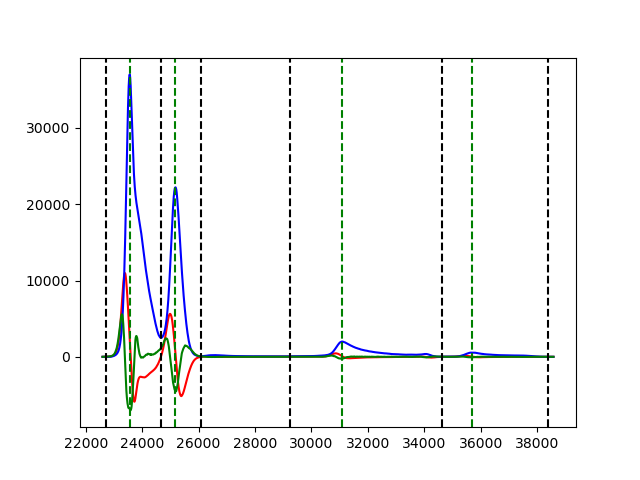

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [13]:
from scipy import interpolate #pk cela n'a pas fonctionné malgré qu'il soit dans la cellule du début
minV = 2**16 
maxV = 0
k = [0]*(2**16)
for i in range(len(data_dir)):
    
    frame = np.asarray(Image.open(data_dir+impathes[i]))
    j = np.bincount(frame.flatten(), minlength = 2**16)
    k = np.add(k, j)
    
    if frame.flatten().min()<minV:
        minV = frame.flatten().min()
    if frame.flatten().max()>maxV:
        maxV = frame.flatten().max()
        
interV = (maxV - minV)
yp = k[0:2**16] 
xp = list(range(0,2**16))
f = interpolate.interp1d(xp, ndimage.gaussian_filter(yp, 10), kind='cubic')


Xi = np.linspace(minV, maxV, interV)
Yi = f(Xi)
h= int(interV*0.01)
dYi = (f(Xi+h)-f(Xi-h))/(2*h)
ddYi = np.gradient(ndimage.gaussian_filter(dYi, 10))                      

# for local maxima
j = argrelextrema(Yi, np.greater, order = 8*int(interV/100)) #order 9 ou 8

# for local minima
g = argrelextrema(Yi, np.less, order = 3*int(interV/100), mode='clip')

plt.figure()
plt.plot(Xi, 100*dYi, "-r")
plt.plot(Xi, Yi,"-b")
plt.plot(Xi, 10000*ddYi, "-g")

xgcoords = Xi[g]
for xc in xgcoords:
    plt.axvline(x=xc, color='k', linestyle='--')
    
xjcoords = Xi[j]
for xc in xjcoords:
    plt.axvline(x=xc, color='g', linestyle='--')
plt.show()

lim = []
for i in range(len(object_list)):
    ainf = np.array(g)[np.array(g) < j[0][i]].max()
    asupp = np.array(g)[np.array(g) > j[0][i]].min()
    lim.append([ainf, asupp])

k

## Création des images segmentées avec méthode unique

In [31]:
lim = SegHist(data_dir, impathes)[0]
for q in range(len(object_list)) :
    limmin = lim[q][0]
    limmax = lim[q][1]
    for i in range(len(impathes)) : 
        frame = np.asarray(Image.open(data_dir+impathes[i]))
        coordonates_in = GetPixelValueBetween(frame, limmin, limmax)
        coordonates_out = GetPixelValueOutside(frame, limmin, limmax)
        frame1 = ChangePixelValue(frame, coordonates_in, 2**16-1)
        frame2 = ChangePixelValue(frame1, coordonates_out, 0)
        frame3 = (frame2/256).astype('uint8')
        ims = Image.fromarray(frame3)
        ims.save(child_dir+object_list[q]+'/'+object_list[q]+"{0}.tif".format(i), compression = None)

KeyboardInterrupt: 

## Création des images segmentées avec méthode multiple 

In [ ]:
limnew = SegHist(data_dir, impathes)[1]
for q in range(len(object_list)) :
    limin_inf, limin_supp, between_inf, between_supp, cond, between = limits(object_list, limnew)
    for i in range(len(impathes)) :
        frame = np.asarray(Image.open(data_dir+impathes[i]))
        coordonates_out = GetPixelValueOutside(frame, limnew[q][0], limnew[q][1])
        frame1 = ChangePixelValue(frame, coordonates_out, 0)
        coordonates_in = GetPixelValueBetween(frame1, limin_inf, limin_supp)
        frame2 = ChangePixelValue(frame1, coordonates_in, 2**16-1)
        if cond==0 : 
            frame_rgb = ImageGrayToRGB(frame2)
        if cond==1 : 
            coordonates_between = GetPixelValueBetween(frame2, between_inf, between_supp)
            frame_rgb = ChangePixelValueGrayToRGB(frame2, coordonates_between, 2**16-1,0,0)
        if cond==2 : 
            coordonates_between = GetPixelValueBetweenSeveral(frame2, between)
            frame_rgb = ChangePixelValueGrayToRGB(frame2, coordonates_between, 2**16-1,0,0)
        ims = Image.fromarray(frame_rgb)
        ims.save(child_dir1+object_list[q]+'/'+object_list[q]+"{0}.tif".format(i), compression = None)

## Volume

In [ ]:
vx = 0.07
vy = 0.07
vz = 0.07
k = [0]*2**16
import numpy as np

segmented = []
volume = [0]*(len(object_list))

for z in range(len(object_list)) :
    addition = sorted([f for f in os.listdir(child_dir+object_list[z]) if f.endswith(format_type)])
    segmented.append(addition)
    

for j in range(len(object_list)):
    for i in range(len(impathes)):
        frame = np.asarray(Image.open(child_dir+object_list[j]+'/'+segmented[j][i]))
        frame = frame.astype(np.uint16)
        b = np.bincount(frame.flatten(), minlength = 2**16)
        k = np.add(k, b)
    volume = (k.sum())*vx*vy*vz
    print('Size of ' + object_list[j] + ' = ' + str(volume) + 'mm^3')



In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Histogramme et son Image')
ax1.hist(frame.flatten())

ax2.imshow(frame_r, cmap=plt.cm.gray)
plt.show()

In [ ]:
numba.typeof(frame)

In [14]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [17]:
n = np.sum(k)
n

35665920

In [20]:
864*860

743040

In [32]:
def SegHistGlobal(all_of_frame, object_list):


    m = np.bincount(all_of_frame, minlength = 2**16)
    minV = min_val_above (all_of_frame.flatten(), 0)
    maxV = all_of_frame.flatten().max()

    interV = (maxV - minV)
    yp = m[0:2**16] 
    xp = list(range(0,2**16))
    f = interpolate.interp1d(xp, ndimage.gaussian_filter(yp, 100), kind='cubic')


    Xi = np.linspace(minV, maxV, interV)
    Yi = f(Xi)
    h= int(interV*0.01)
    dYi = (f(Xi+h)-f(Xi-h))/(2*h)
    ddYi = np.gradient(ndimage.gaussian_filter(dYi, 100))                      

    # for local maxima
    j = argrelextrema(Yi, np.greater, order = 100) #order 9 ou 8
    j = np.array(j).flatten()
    j1 =[]
    for i in range(len(j)):
        if Yi[j[i]] > 1000 :
            j1.append(int(j[i]))
    j = j1
        
    b = argrelextrema(ddYi, np.less, order = 100)
    b = np.array(b).flatten()
    b1 = []
    for i in range(len(b)):
        if Yi[b[i]] > 1000 :
            b1.append(int(b[i]))
    b = b1   
    
    j2 = []
    for i in range(len(j)):
        for l in range(len(b)):
            if abs(Xi[j[i]]-Xi[b[l]])<300: 
                j2.append(j[i])
                break
    j=j2
        

    plt.figure()
    plt.xlim(minV, maxV)
    plt.plot(Xi, 100*dYi, "-r")
    plt.plot(Xi, Yi,"-b")
    plt.plot(Xi, 10000*ddYi, "-g")
    
    xjcoords = Xi[j]
    for xc in xjcoords:
        plt.axvline(x=xc, color='g', linestyle='--')
    xjcoords = Xi[b]
    for xc in xjcoords:
        plt.axvline(x=xc, color='b', linestyle='--')
  
    plt.show() 
    return j

In [33]:
def SumAllFrame(data_dir):
    from time import sleep
    from tqdm import tqdm
    all_frame = []
    all_of_frame = []
    impathes1 = sorted([f for f in os.listdir(data_dir) if f.endswith(format_type)])
    for i in tqdm(range(len(impathes))):
        frame = np.asarray(Image.open(data_dir+'/'+impathes1[i])).flatten()
        all_frame =np.concatenate([all_frame, frame], axis=0)
        if len(all_frame) > ((frame.shape[0])*((1/20)*len(impathes))):
            all_of_frame = np.concatenate([all_of_frame, all_frame], axis=0)
            all_frame = []
    all_of_frame =np.concatenate([all_of_frame, all_frame], axis=0)
    all_of_frame = all_of_frame.astype(int)
    return all_of_frame

In [34]:
# all_of_frame = SumAllFrame("D://Segmentation_multiple/vide")
all_of_frame = SumAllFrame(data_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 1230/1230 [02:13<00:00,  9.19it/s]


In [ ]:
j = SegHistGlobal(all_of_frame, object_list)


In [ ]:
type(all_frame[0])

In [20]:
frame = np.asarray(Image.open(child_dir+object_list[0]+'/'+object_list[0]+"0.tif"))
frame.dtype

dtype('uint8')

In [ ]:
for i in range(len(impathes)):
    frame = np.asarray(Image.open(data_dir+impathes[i]))
    grad_x, grad_y = np.gradient(rescaler(frame))
    img_grad = np.sqrt(grad_x**2 + grad_y**2)
    coordonates_grad = GetPixelValueBetween(img_grad, 0.02, 1)
    frame1 = ChangePixelValue(frame, coordonates_grad, 0)
    ims = Image.fromarray(frame1)
    ims.save(child_dir1+object_list[0]+'/'+object_list[0]+"{0}.tif".format(i), compression = None)

In [ ]:
from scipy import interpolate #pk cela n'a pas fonctionné malgré qu'il soit dans la cellule du début

    
frame = np.asarray(Image.open(child_dir1+object_list[0]+'/'+object_list[0]+"1103.tif"))
a = np.bincount(frame.flatten(), minlength = 2**16)
a[0] = 0

minV = min_val_above (frame, 0)
maxV = frame.flatten().max()
        
interV = (maxV - minV)
yp = a 
xp = list(range(0,2**16))
f = interpolate.interp1d(xp, ndimage.gaussian_filter(yp, 100), kind='cubic')


Xi = np.linspace(minV, maxV, interV)
Yi = f(Xi)
h= int(interV*0.01)
dYi = np.gradient(ndimage.gaussian_filter(Yi, 100))   
ddYi = np.gradient(ndimage.gaussian_filter(dYi, 100))                      

# for local maxima
j = argrelextrema(Yi, np.greater, order = 5*int(interV/100)) #order 9 ou 8
j = np.array(j).flatten()
for i in range(len(j)):
    if Yi[j[i]] < 2 :
        j1 = np.delete(j, i)
if 'j1' in locals() and j1!=None:
    j=j1
    j1 = None 

# for local minima
g = argrelextrema(Yi, np.less, order = 2*int(interV/100), mode='clip')

b = argrelextrema(ddYi, np.less, order = 8*int(interV/100), mode='clip')
b = np.array(b).flatten()
for i in range(len(b)):
    if Yi[b[i]] < 2 :
        b1 = np.delete(b, i)
if 'b1' in locals() and b1!=None:
    b=b1
    b1 = None 

plt.figure()
plt.xlim(minV, maxV)
plt.plot(Xi, 100*dYi, "-r")
plt.plot(Xi, Yi,"-b")
plt.plot(Xi, 10000*ddYi, "-g")

xgcoords = Xi[g]
for xc in xgcoords:
    plt.axvline(x=xc, color='k', linestyle='--')
    
xjcoords = Xi[j]
for xc in xjcoords:
    plt.axvline(x=xc, color='g', linestyle='--')
plt.show()

xjcoords = Xi[b]
for xc in xjcoords:
    plt.axvline(x=xc, color='b', linestyle='--')
plt.show()

lim = []
for i in range(len(j)):
    ainf = int(Xi[np.array(g)[np.array(g) < j[0]].max()])
    asupp = int(Xi[np.array(g)[np.array(g) > j[i]].min()])
    lim.append([ainf, asupp])